In [1]:
import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
import albumentations as A
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, TensorDataset
import os
import cv2
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from collections import defaultdict
import random

In [2]:
class MyDataset(Dataset):
    def __init__(self,
                 images_folder,
                 transform=None,
                 *args, **kwargs):

        super().__init__(*args, **kwargs)

        self.images_folder = images_folder

        self.transform = transform if transform else \
            A.Compose(
                [
                    ToTensorV2(),
                ]
            )
        self.model_transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

        self.folder_to_files = defaultdict(list) # folder: [file1, file2]
        self.image_folders = []
        self._read_images_names()

    def _read_images_names(self):
        for root, dirs, files in os.walk(self.images_folder):
            for image_name in files:
                img_path = os.path.join(root, image_name)

                _, ext = os.path.splitext(img_path)
                if ext not in ['.png', '.jpg', '.jpeg']:
                    continue
                self.folder_to_files[root].append(img_path)

            if len(self.folder_to_files.get(root, [])):
                self.image_folders.append(root)

    def __len__(self):
        return len(self.folder_to_files)
    
    def get_original_image(self, idx):
        image_folder = self.image_folders[idx]

        img_path = self.folder_to_files[image_folder][
            np.random.randint(
                len(self.folder_to_files[image_folder])
            )
        ]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        return image

    def __getitem__(self, idx):
        image_folder = self.image_folders[idx]
        res = []

        for img_path in self.folder_to_files[image_folder]:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = self.transform(image=image)["image"]
            image = self.model_transform(image)
            res.append(image.float())

        idxs = np.random.choice(len(res), size=10)
        res = [res[idx] for idx in idxs]
        
        return torch.stack(res)

In [3]:
my_dataset = MyDataset(images_folder="/Users/alex-usatoff/Downloads/VisDrone2020-CC/sequences")

In [4]:
len(my_dataset)

112

In [5]:
class EmbeddingsExtractor(pl.LightningModule):

    def __init__(self):
        super(EmbeddingsExtractor, self).__init__()

        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        self.model.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
        )

        for name, param in self.model.named_parameters():
            # if "fc" in name or "layer4" in name or "layer3" in name:
            #     continue
            param.requires_grad = False

        # self.device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.model.to(self.device)

    def forward(self, x):
        return self.model(x)

    def get_embedings(self, dataset):
        dataloader = DataLoader(dataset, batch_size=1)
        self.eval()
        embeds = []
        with torch.no_grad():
            for batch in dataloader:
                item_dataset = TensorDataset(batch[0])
                item_dataloader = DataLoader(item_dataset, batch_size=30)
                item_outputs = []
                for (item_batch,) in item_dataloader:
                    item_batch = item_batch.to(self.device)
                    outputs = self(item_batch)
                    item_outputs.append(outputs)
                embeds.append(torch.cat(item_outputs).mean(axis=0))
        return torch.stack(embeds)

In [6]:
my_dataset_1, my_dataset_2 = torch.utils.data.Subset(
    my_dataset, 
    range(
        len(my_dataset) // 2)
    ), \
    torch.utils.data.Subset(
        my_dataset, 
        range(len(my_dataset) // 2, 
        len(my_dataset))
    )

In [7]:
import torch.utils
import torch.utils.data


def get_embeds_example(dataset, extractor, subsample_size=1_000, random_seed=42):
    np.random.seed(random_seed)
    subsample_size = min(subsample_size, len(dataset))
    idxs = np.random.choice(range(len(dataset)), subsample_size, replace=False)
    subset = torch.utils.data.Subset(dataset, idxs)
    
    embeds = extractor.get_embedings(subset)
    return embeds

In [8]:
extractor = EmbeddingsExtractor()

In [9]:
get_embeds_example(my_dataset, extractor, 10).shape

torch.Size([10, 512])

In [10]:
embeds1, embeds2 = get_embeds_example(my_dataset_1, extractor, subsample_size=100, random_seed=42), \
    get_embeds_example(my_dataset_2, extractor, subsample_size=100, random_seed=69)

In [11]:
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error as mse
from itertools import product

def _mean_similarity(emb1, emb2):

    sim_sum = 0
    for el1 in emb1:
        for el2 in emb2:
            sim_sum += np.dot(el1, el2) / (np.linalg.norm(el1) * np.linalg.norm(el2))
    
    return sim_sum / len(emb1) / len(emb2)


def embeds_list_similarity(emb1, emb2):
    emb1, emb2 = np.array(emb1), np.array(emb2)

    return np.mean(_mean_similarity(emb1, emb2))

In [12]:
embeds_list_similarity(embeds1, embeds2)

0.714082264797572

In [13]:
def get_similarities(ds1, ds2, subsample_1_size=100, subsample_2_size=100, iters=100):
    similarities_list = []
    for seed in tqdm(range(iters)):
        embeds1, embeds2 = get_embeds_example(
            ds1, extractor, random_seed=seed, subsample_size=subsample_1_size), get_embeds_example(
                ds2, extractor, random_seed=seed**2, subsample_size=subsample_2_size)
        similarities_list.append(embeds_list_similarity(embeds1, embeds2))
    return similarities_list

In [14]:
similarities_list = get_similarities(my_dataset_1, my_dataset_2, subsample_1_size=40, subsample_2_size=7, iters=20)

  0%|          | 0/20 [00:00<?, ?it/s]

In [15]:
similarities_list

[0.7100017053740365,
 0.7248252889939717,
 0.7315087961299078,
 0.6888254833008561,
 0.7335014424153737,
 0.7011847027710506,
 0.7329125717282295,
 0.7289483877164977,
 0.7113488510251046,
 0.6876404281173434,
 0.7356005574975695,
 0.7242553787572044,
 0.7209409971322333,
 0.7029358299715179,
 0.7431511842778751,
 0.7199251430375236,
 0.7506595996873718,
 0.6906252784388406,
 0.698785263299942,
 0.7056176481502396]

(array([1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.68764043, 0.68827062, 0.68890081, 0.689531  , 0.69016119,
        0.69079139, 0.69142158, 0.69205177, 0.69268196, 0.69331215,
        0.69394235, 0.69457254, 0.69520273, 0.69583292, 0.69646311,
        0.6970933 , 0.6977235 , 0.69835369, 0.69898388, 0.69961407,
        0.70024426, 0.70087445, 0.70150465, 0.70213484, 0.70276503,
        0.70339522, 0.70402541, 0.7046556 , 0.7052858 , 0.70591599,
        0.70654618, 0.70717637, 0.70780656, 0.70843675, 0.70906695,
        0.70969714, 0.71032733, 0.71095752, 0.71158771, 0.71221791,
      

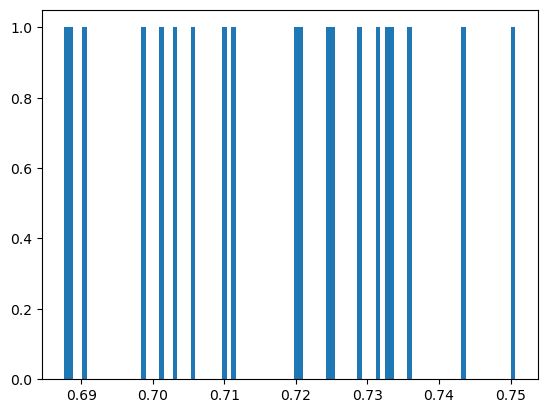

In [16]:
plt.hist(similarities_list, bins=100, range=[min(similarities_list), max(similarities_list)])

In [27]:
test_dataset = MyDataset(images_folder="/Users/alex-usatoff/Downloads/VisDrone2019-MOT-train/sequences")
len(test_dataset), len(my_dataset)

(56, 112)

In [28]:
similarities_test_list_1 = get_similarities(my_dataset_1, test_dataset, subsample_1_size=40, subsample_2_size=40, iters=20)

  0%|          | 0/20 [00:00<?, ?it/s]

In [29]:
similarities_test_list_1

[0.6874136847443879,
 0.6837325412966311,
 0.6849031346105039,
 0.6874000068753958,
 0.6914032184705138,
 0.6872852578014135,
 0.6889598178490997,
 0.6906120791099966,
 0.6952100113779307,
 0.6847365799173712,
 0.6848292483016849,
 0.6911263685487211,
 0.6893944414705038,
 0.6857900481484831,
 0.6917814508080482,
 0.6899249005876482,
 0.6924327178671956,
 0.6898643854446709,
 0.687125147730112,
 0.6849442821927368]

(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.68373254, 0.68384732, 0.68396209, 0.68407687, 0.68419164,
        0.68430641, 0.68442119, 0.68453596, 0.68465074, 0.68476551,
        0.68488029, 0.68499506, 0.68510984, 0.68522461, 0.68533939,
        0.68545416, 0.68556894, 0.68568371, 0.68579849, 0.68591326,
        0.68602804, 0.68614281, 0.68625758, 0.68637236, 0.68648713,
        0.68660191, 0.68671668, 0.68683146, 0.68694623, 0.68706101,
        0.68717578, 0.68729056, 0.68740533, 0.68752011, 0.68763488,
        0.68774966, 0.68786443, 0.68797921, 0.68809398, 0.68820875,
      

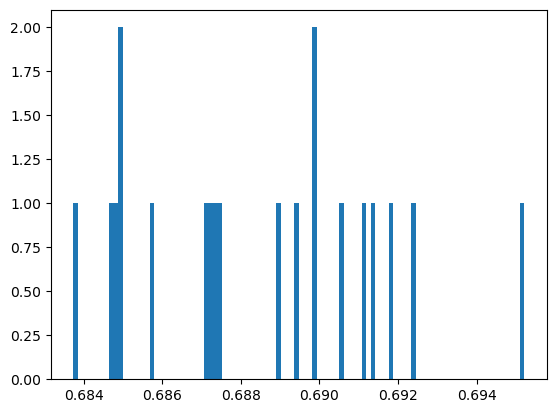

In [30]:
plt.hist(similarities_test_list_1, bins=100, range=[min(similarities_test_list_1), max(similarities_test_list_1)])

In [31]:
similarities_test_list_2 = get_similarities(my_dataset_2, test_dataset, subsample_1_size=40, subsample_2_size=7, iters=20)

  0%|          | 0/20 [00:00<?, ?it/s]

In [32]:
similarities_test_list_2

[0.6903692124145372,
 0.6826465664165361,
 0.69387529364654,
 0.6831816392285484,
 0.6759965722049985,
 0.6748782131288733,
 0.6793862198080335,
 0.6707994414227348,
 0.6863649183085986,
 0.6821977021438734,
 0.6763749991144453,
 0.6938557012804917,
 0.6790899741862502,
 0.6877584332866328,
 0.6803531165633883,
 0.6905871241220406,
 0.6840794512203762,
 0.6633827144546168,
 0.6693911103265625,
 0.6759206514273371]

(array([1., 0., 0., 1., 1., 0., 0., 1., 3., 0., 2., 1., 3., 1., 0., 2., 0.,
        2., 0., 2.]),
 array([0.66338271, 0.66490734, 0.66643197, 0.6679566 , 0.66948123,
        0.67100586, 0.67253049, 0.67405512, 0.67557975, 0.67710438,
        0.678629  , 0.68015363, 0.68167826, 0.68320289, 0.68472752,
        0.68625215, 0.68777678, 0.68930141, 0.69082604, 0.69235066,
        0.69387529]),
 <BarContainer object of 20 artists>)

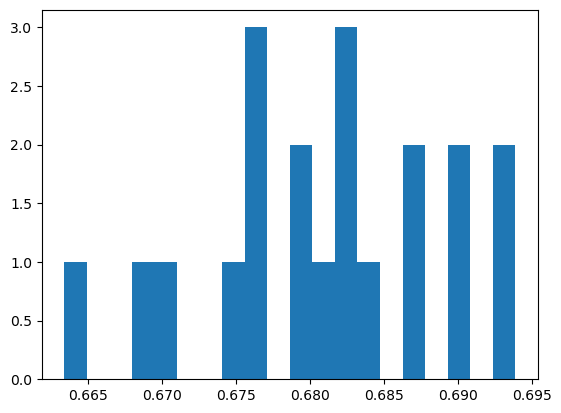

In [33]:
plt.hist(similarities_test_list_2, bins=20, range=[min(similarities_test_list_2), max(similarities_test_list_2)])

In [34]:
def plot_images(dataset, cnt, random_state=42):
    np.random.seed(random_state)

    idxs = np.random.choice(range(len(dataset)), cnt, replace=False)

    rows = int(np.ceil(cnt ** 0.5))
    cols = cnt // rows
    rows = int(np.ceil(cnt / cols))
    
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

    for i, idx in enumerate(idxs):
        axs[i // cols, i % cols].imshow(dataset.get_original_image(idx))

    plt.show()

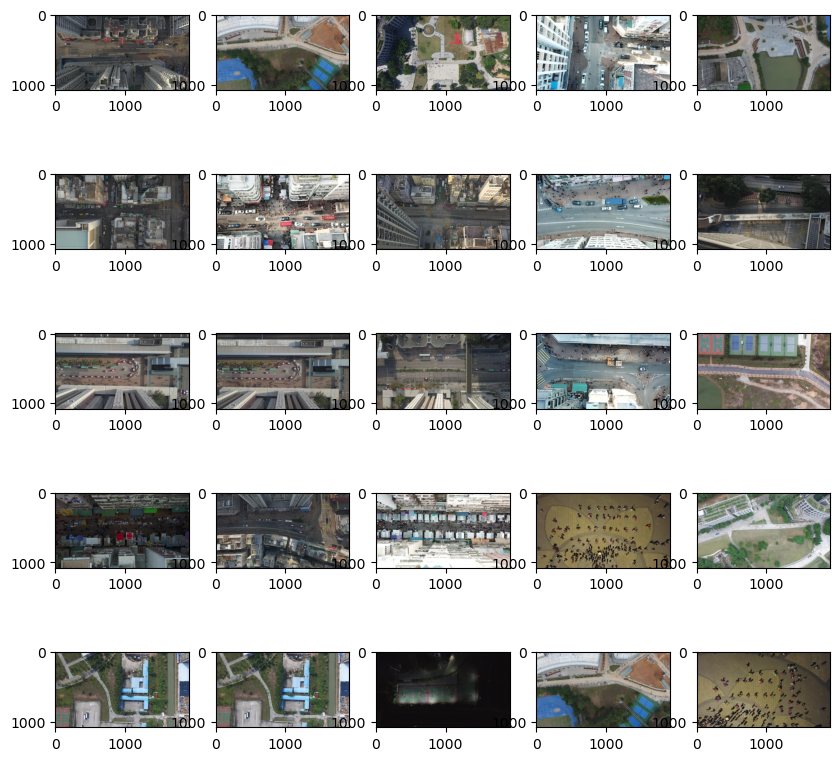

In [45]:
plot_images(my_dataset, 25)

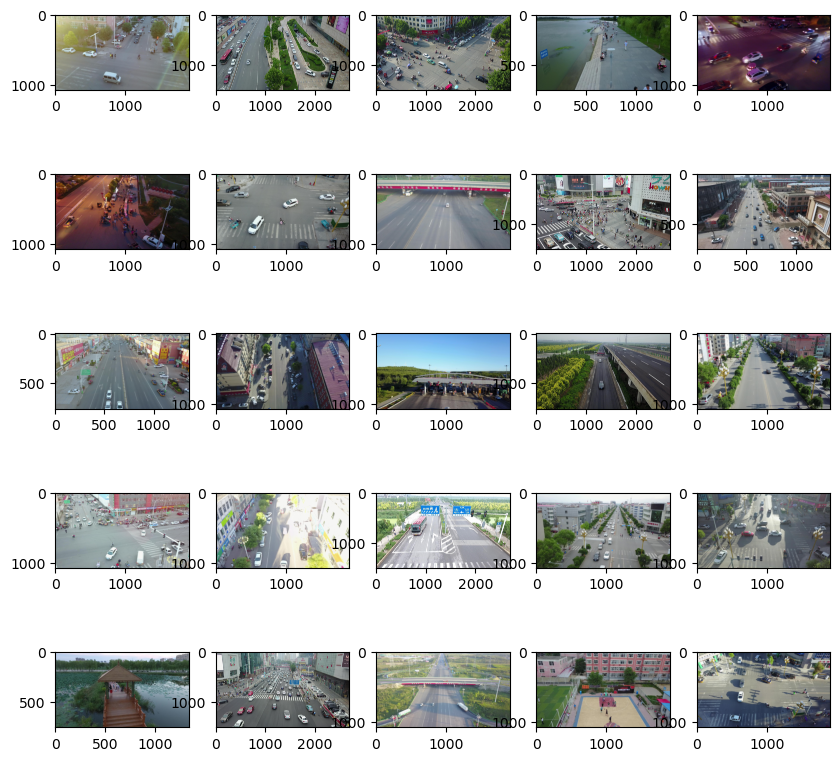

In [44]:
plot_images(test_dataset, 25)